# Example Predictor: Linear Rollout Predictor

This example contains basic functionality for training and evaluating a linear predictor that rolls out predictions day-by-day.

First, a training data set is created from historical case and npi data.

Second, a linear model is trained to predict future cases from prior case data along with prior and future npi data.
The model is an off-the-shelf sklearn Lasso model, that uses a positive weight constraint to enforce the assumption that increased npis has a negative correlation with future cases.

Third, a sample evaluation set is created, and the predictor is applied to this evaluation set to produce prediction results in the correct format.

## Training

In [1]:
import requests
import datetime
import pickle

import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

import ipywidgets as widgets
from ipywidgets import interact

import matplotlib.pyplot as plt
from matplotlib.dates import (DateFormatter, MO, WeekdayLocator)
import seaborn as sns

import transat

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

### Copy the data locally

In [3]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

In [4]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x7ff52459fcd0>)

In [13]:
# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [14]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [15]:
# For testing, restrict training data to that before a hypothetical predictor submission date
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-07-31")
# df_test = df[df.Date > HYPOTHETICAL_SUBMISSION_DATE]
# df = df[df.Date <= HYPOTHETICAL_SUBMISSION_DATE]

In [16]:
# Add RegionID column that combines CountryName and RegionName for easier manipulation of data
df['GeoID'] = df['CountryName'] + '__' + df['RegionName'].astype(str)

In [17]:
# Add new cases column
df['NewCases'] = df.groupby('GeoID').ConfirmedCases.diff().fillna(0)

In [18]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
cases_col = ['NewCases']
npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']
df = df[id_cols + cases_col + npi_cols]

In [19]:
def plot_normalized_new_confirmed_cases(country):
    subdf = df.loc[df["CountryName"] == country]
    x = subdf["Date"].tolist()
    
    width = 5
    height = width/1.618
    fig = plt.figure(figsize=(width,height))
    plt.title(country)
    
    dates = pd.to_datetime(pd.Series([str(xi) for xi in x]), format = '%Y-%m-%d').tolist()
    
    plt.plot_date(dates, subdf["NewCases"], ".", markersize=2, label="new cases")
    
    loc = WeekdayLocator(byweekday=MO, interval=3)
    formatter = DateFormatter('%d/%m/%y')

    ax = plt.gca()
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)

    plt.ylabel("Number of 'legend'")
    plt.xlabel("Dates")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
countries = sorted(df.CountryName.unique())

w_countries = widgets.Dropdown(
    options=countries,
    value='France',
    description='Country:',
    disabled=False
)

interact(plot_normalized_new_confirmed_cases, country=w_countries)

interactive(children=(Dropdown(description='Country:', index=60, options=('Afghanistan', 'Albania', 'Algeria',…

<function __main__.plot_normalized_new_confirmed_cases(country)>

In [20]:
# Fill any missing case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))

In [21]:
def plot_normalized_new_confirmed_cases(country):
    subdf = df.loc[df["CountryName"] == country]
    x = subdf["Date"].tolist()
    
    width = 5
    height = width/1.618
    fig = plt.figure(figsize=(width,height))
    plt.title(country)
    
    dates = pd.to_datetime(pd.Series([str(xi) for xi in x]), format = '%Y-%m-%d').tolist()
    
    plt.plot_date(dates, subdf["NewCases"], ".", markersize=2, label="new cases")
    
    loc = WeekdayLocator(byweekday=MO, interval=3)
    formatter = DateFormatter('%d/%m/%y')

    ax = plt.gca()
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)

    plt.ylabel("Number of 'legend'")
    plt.xlabel("Dates")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
countries = sorted(df.CountryName.unique())

w_countries = widgets.Dropdown(
    options=countries,
    value='France',
    description='Country:',
    disabled=False
)

interact(plot_normalized_new_confirmed_cases, country=w_countries)

interactive(children=(Dropdown(description='Country:', index=60, options=('Afghanistan', 'Albania', 'Algeria',…

<function __main__.plot_normalized_new_confirmed_cases(country)>

In [22]:
# Fill any missing NPIs by assuming they are the same as previous day
for npi_col in npi_cols:
    df.update(df.groupby('GeoID')[npi_col].ffill().fillna(0))

In [23]:
df

,CountryName,RegionName,GeoID,Date,NewCases,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H6_Facial Coverings
0,Aruba,NaN,Aruba__nan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,NaN,Aruba__nan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,NaN,Aruba__nan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,NaN,Aruba__nan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,NaN,Aruba__nan,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92829,Zimbabwe,NaN,Zimbabwe__nan,2020-12-10,74.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
92830,Zimbabwe,NaN,Zimbabwe__nan,2020-12-11,81.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
92831,Zimbabwe,NaN,Zimbabwe__nan,2020-12-12,57.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
92832,Zimbabwe,NaN,Zimbabwe__nan,2020-12-13,27.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0


In [24]:
df_test = df[df.Date > HYPOTHETICAL_SUBMISSION_DATE]
df = df[df.Date <= HYPOTHETICAL_SUBMISSION_DATE]

In [25]:
# Set number of past days to use to make predictions
nb_lookback_days = 30

# Create training data across all countries for predicting one day ahead
X_cols = cases_col + npi_cols
y_col = cases_col
X_samples = []
y_samples = []
geo_ids = df.GeoID.unique()
for g in geo_ids:
    gdf = df[df.GeoID == g]
    all_case_data = np.array(gdf[cases_col])
    all_npi_data = np.array(gdf[npi_cols])

    # Create one sample for each day where we have enough data
    # Each sample consists of cases and npis for previous nb_lookback_days
    nb_total_days = len(gdf)
    for d in range(nb_lookback_days, nb_total_days - 1):
        X_cases = all_case_data[d-nb_lookback_days:d]

        # Take negative of npis to support positive
        # weight constraint in Lasso.
        X_npis = -all_npi_data[d - nb_lookback_days:d]

        # Flatten all input data so it fits Lasso input format.
        X_sample = np.concatenate([X_cases.flatten(),
                                   X_npis.flatten()])
        y_sample = all_case_data[d + 1]
        X_samples.append(X_sample)
        y_samples.append(y_sample)

X_samples = np.array(X_samples)
y_samples = np.array(y_samples).flatten()

In [26]:
print(np.shape(X_samples))
print(np.shape(y_samples))
print("Number of features per day: " ,390/nb_lookback_days)

(48412, 390)
(48412,)
Number of features per day:  13.0


In [27]:
# Helpful function to compute mae
def mae(pred, true):
    return np.mean(np.abs(pred - true))

## Standard Train Test Split

In [28]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_samples,
                                                    y_samples,
                                                    test_size=0.2,
                                                    random_state=301)

In [29]:
# Create and train Lasso model.
# Set positive=True to enforce assumption that cases are positively correlated
# with future cases and npis are negatively correlated.
model = Lasso(alpha=0.1,
              precompute=True,
              max_iter=10000,
              positive=True,
              selection='random')
# Fit model
model.fit(X_train, y_train)

Lasso(alpha=0.1, max_iter=10000, positive=True, precompute=True,
      selection='random')

In [30]:
# Evaluate model
train_preds = model.predict(X_train)
train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
print('Train MAE:', mae(train_preds, y_train))

test_preds = model.predict(X_test)
test_preds = np.maximum(test_preds, 0) # Don't predict negative cases
print('Test MAE:', mae(test_preds, y_test))

Train MAE: 144.76191695486287
Test MAE: 144.08534469294466


In [31]:
HYPOTHETICAL_SUBMISSION_DATE

numpy.datetime64('2020-07-31')

In [32]:
geo_ids = df.GeoID.unique()
print("France__nan" in geo_ids)
print(geo_ids)

True
['Aruba__nan' 'Afghanistan__nan' 'Angola__nan' 'Albania__nan'
 'Andorra__nan' 'United Arab Emirates__nan' 'Argentina__nan'
 'Australia__nan' 'Austria__nan' 'Azerbaijan__nan' 'Burundi__nan'
 'Belgium__nan' 'Benin__nan' 'Burkina Faso__nan' 'Bangladesh__nan'
 'Bulgaria__nan' 'Bahrain__nan' 'Bahamas__nan'
 'Bosnia and Herzegovina__nan' 'Belarus__nan' 'Belize__nan' 'Bermuda__nan'
 'Bolivia__nan' 'Brazil__Acre' 'Brazil__Alagoas' 'Brazil__Amazonas'
 'Brazil__Amapa' 'Brazil__Bahia' 'Brazil__Ceara'
 'Brazil__Distrito Federal' 'Brazil__Espirito Santo' 'Brazil__Goias'
 'Brazil__Maranhao' 'Brazil__Minas Gerais' 'Brazil__Mato Grosso do Sul'
 'Brazil__Mato Grosso' 'Brazil__Para' 'Brazil__Paraiba'
 'Brazil__Pernambuco' 'Brazil__Piaui' 'Brazil__Parana'
 'Brazil__Rio de Janeiro' 'Brazil__Rio Grande do Norte' 'Brazil__Rondonia'
 'Brazil__Roraima' 'Brazil__Rio Grande do Sul' 'Brazil__Santa Catarina'
 'Brazil__Sergipe' 'Brazil__Sao Paulo' 'Brazil__Tocantins' 'Brazil__nan'
 'Barbados__nan' 'Brunei__na

In [38]:
geo_id = "France__nan"

# Set number of past days to use to make predictions
nb_lookback_days = 30

# Create training data across all countries for predicting one day ahead
X_cols = cases_col + npi_cols
y_col = cases_col
X = []

gdf = df[df.GeoID == geo_id]
all_case_data = np.array(gdf[cases_col])
all_npi_data = np.array(gdf[npi_cols])

# Create one sample for each day where we have enough data
# Each sample consists of cases and npis for previous nb_lookback_days
nb_total_days = len(gdf)
d = -1

X_cases = all_case_data[d-nb_lookback_days:d]

# Take negative of npis to support positive
# weight constraint in Lasso.
X_npis = -all_npi_data[d - nb_lookback_days:d]

# Flatten all input data so it fits Lasso input format.
X_sample = np.concatenate([X_cases.flatten(),
                           X_npis.flatten()])

X.append(X_sample)

X = np.array(X)

In [39]:
nb_future_days = 30

X_npis_, X_cases_ = X_npis.copy(), X_cases.copy()
X_ = X.copy()

y_preds = []

for d in range(nb_future_days):

    y_ = model.predict(X_)

    y_preds.append(y_[0])

    # Assuming constant NPIs here
    X_npis_ = np.concatenate([X_npis_[-(nb_lookback_days-1):], X_npis_[-1:]], axis=0)
    X_cases_ = np.concatenate([X_cases_[-(nb_lookback_days-1):], y_.reshape(-1, 1)], axis=0)
    X_ =  np.concatenate([X_cases_.flatten(), X_npis_.flatten()])
    X_ = np.array([X_])



In [40]:
y_col = cases_col


gdf = df_test[df_test.GeoID == geo_id]
all_case_data = np.array(gdf[cases_col])

y_true = list(all_case_data[:nb_future_days].flatten())

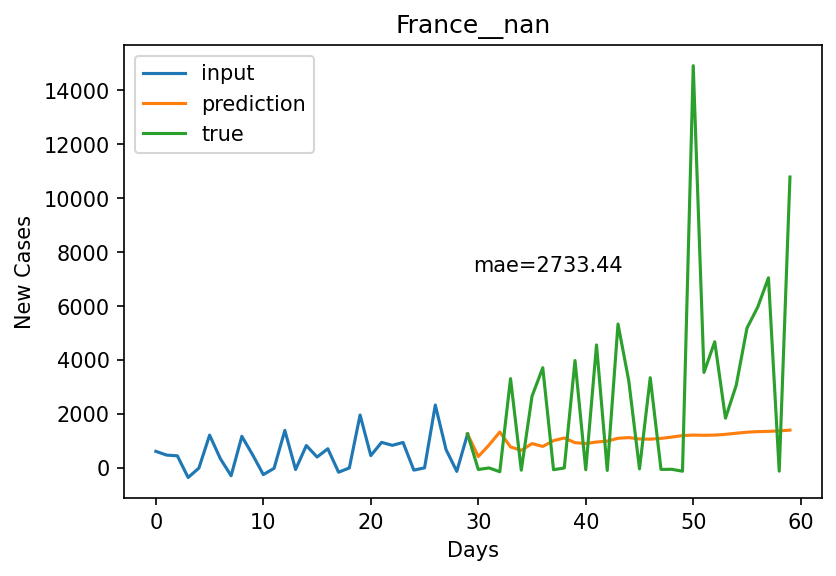

In [41]:
y_in = list(X_cases.flatten())
x_in = list(range(len(y_in)))


y_out = list(y_in[-1:]) + list(y_preds)
x_out = x_in[-1:] + [i+len(x_in) for i in range(len(y_out)-1)]

y_true_plot = list(y_in[-1:]) + y_true
x_true_plot = x_out

mae_error = mae(np.array(y_preds), np.array(y_true))

plt.figure()
plt.title(geo_id)
plt.plot(x_in, y_in, label="input")
plt.plot(x_out, y_out, label="prediction")
plt.plot(x_true_plot, y_true_plot, label="true")
plt.ylabel("New Cases")
plt.xlabel("Days")
ax = plt.gca()
plt.text(0.5, 0.5, f"mae={mae_error:.2f}", transform=ax.transAxes)
plt.legend()
plt.show()

## Temporal Train Test Split

In [ ]:
# Set number of past days to use to make predictions
nb_lookback_days = 30

# Create training data across all countries for predicting one day ahead
X_cols = cases_col + npi_cols
y_col = cases_col

# X_samples = []

X_train, y_train = [], []
X_test, y_test = [], []

y_samples = []
geo_ids = df.GeoID.unique()
for g in geo_ids:
    gdf = df[df.GeoID == g]
    all_case_data = np.array(gdf[cases_col])
    all_npi_data = np.array(gdf[npi_cols])

    # Create one sample for each day where we have enough data
    # Each sample consists of cases and npis for previous nb_lookback_days
    nb_total_days = len(gdf)
    for d in range(nb_lookback_days, nb_total_days - 1):
        X_cases = all_case_data[d-nb_lookback_days:d]

        # Take negative of npis to support positive
        # weight constraint in Lasso.
        X_npis = -all_npi_data[d - nb_lookback_days:d]

        # Flatten all input data so it fits Lasso input format.
        X_sample = np.concatenate([X_cases.flatten(),
                                   X_npis.flatten()])
        y_sample = all_case_data[d + 1]
        X_samples.append(X_sample)
        y_samples.append(y_sample)

X_samples = np.array(X_samples)
y_samples = np.array(y_samples).flatten()

In [43]:
from sklearn.model_selection import TimeSeriesSplit

In [49]:
print(np.shape(X_samples))
print(np.shape(y_samples))
print("Number of features per day: " ,390/nb_lookback_days)

number_available_days = np.shape(X_samples)[0]
max_train_size = number_available_days - 30
print("Number of Days available: ", number_available_days)
print("Max Train Size: ", max_train_size)

(48412, 390)
(48412,)
Number of features per day:  13.0
Number of Days available:  48412
Max Train Size:  48382


In [50]:
tscv = TimeSeriesSplit(n_splits=2, max_train_size=max_train_size)

for train_index, test_index in tscv.split(X_samples):
    print(f"TRAIN INDEX: {train_index[0]}=>{train_index[-1]}, TEST: {test_index[0]}=>{test_index[-1]}")
    X_train, X_test = X_samples[train_index], X_samples[test_index]
    y_train, y_test = y_samples[train_index], y_samples[test_index]
    
    # Create and train Lasso model.
    # Set positive=True to enforce assumption that cases are positively correlated
    # with future cases and npis are negatively correlated.
    model = Lasso(alpha=0.1,
                  precompute=True,
                  max_iter=20000,
                  positive=True,
                  selection='random')
    
    # Fit model
    model.fit(X_train, y_train) 
   
    # Evaluate model
    train_preds = model.predict(X_train)
    train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
    print('Train MAE:', mae(train_preds, y_train))

    test_preds = model.predict(X_test)
    test_preds = np.maximum(test_preds, 0) # Don't predict negative cases
    print('Test MAE:', mae(test_preds, y_test))
    print()

TRAIN INDEX: 0=>16137, TEST: 16138=>32274
Train MAE: 202.78154182211506
Test MAE: 123.8485797902486

TRAIN INDEX: 0=>32274, TEST: 32275=>48411
Train MAE: 146.26177736539455
Test MAE: 145.2805975456515



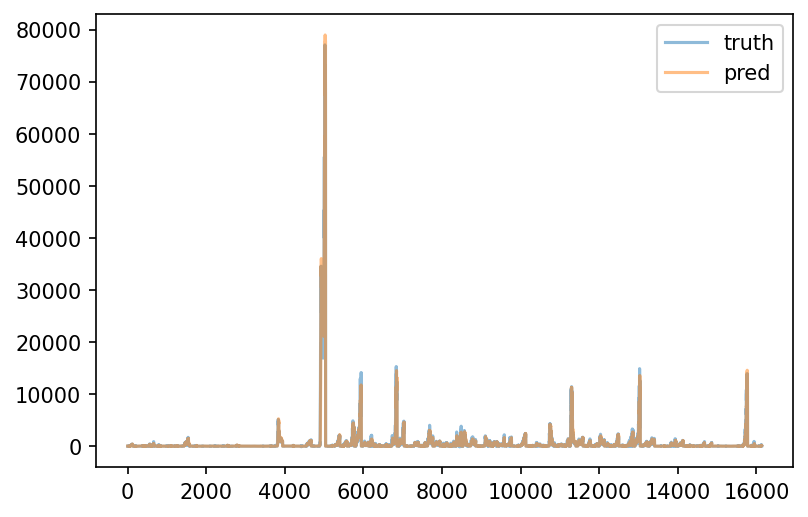

In [53]:
plt.figure()
plt.plot(y_test, alpha=0.5, label="truth")
plt.plot(test_preds, alpha=0.5, label="pred")
plt.legend()
plt.show()

In [42]:
print(np.shape(train_preds))
print(np.shape(test_preds))

(38729,)
(9683,)


In [41]:
# Inspect the learned feature coefficients for the model
# to see what features it's paying attention to.

# Give names to the features
x_col_names = []
for d in range(-nb_lookback_days, 0):
    x_col_names.append('Day ' + str(d) + ' ' + cases_col[0])
for d in range(-nb_lookback_days, 1):
    for col_name in npi_cols:
        x_col_names.append('Day ' + str(d) + ' ' + col_name)

# View non-zero coefficients
for (col, coeff) in zip(x_col_names, list(model.coef_)):
    if coeff != 0.:
        print(col, coeff)
        

Day -7 NewCases 0.04502830911119007
Day -6 NewCases 0.39791569874550614
Day -5 NewCases 0.2342659110126543
Day -4 NewCases 0.05555994147337618
Day -3 NewCases 0.028952820558776543
Day -2 NewCases 0.07127364541444246
Day -1 NewCases 0.2363196228611909
Day -26 C6_Stay at home requirements 10.543180886930438
Day -22 C2_Workplace closing 1.5288795815265857
Day -21 C2_Workplace closing 8.378794612505022
Intercept 28.80631398468313


In [ ]:
# Save model to file
if not os.path.exists('models'):
    os.mkdir('models')
with open('models/model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

## Evaluation

Now that the predictor has been trained and saved, this section contains the functionality for evaluating it on sample evaluation data.

In [ ]:
# Reload the module to get the latest changes
import predict
from importlib import reload
reload(predict)
from predict import predict_df

In [ ]:
%%time
preds_df = predict_df("2020-08-01", "2020-08-31", path_to_ips_file="../../../validation/data/2020-09-30_historical_ip.csv", verbose=True)

In [ ]:
# Check the predictions
preds_df.head()

# Validation
This is how the predictor is going to be called during the competition.  
!!! PLEASE DO NOT CHANGE THE API !!!

In [ ]:
!python predict.py -s 2020-08-01 -e 2020-08-04 -ip ../../../validation/data/2020-09-30_historical_ip.csv -o predictions/2020-08-01_2020-08-04.csv

In [ ]:
!head predictions/2020-08-01_2020-08-04.csv

# Test cases
We can generate a prediction file. Let's validate a few cases...

In [ ]:
import os
from covid_xprize.validation.predictor_validation import validate_submission

def validate(start_date, end_date, ip_file, output_file):
    # First, delete any potential old file
    try:
        os.remove(output_file)
    except OSError:
        pass
    
    # Then generate the prediction, calling the official API
    !python predict.py -s {start_date} -e {end_date} -ip {ip_file} -o {output_file}
    
    # And validate it
    errors = validate_submission(start_date, end_date, ip_file, output_file)
    if errors:
        for error in errors:
            print(error)
    else:
        print("All good!")

## 4 days, no gap
- All countries and regions
- Official number of cases is known up to start_date
- Intervention Plans are the official ones

In [ ]:
validate(start_date="2020-08-01",
         end_date="2020-08-04",
         ip_file="../../../validation/data/2020-09-30_historical_ip.csv",
         output_file="predictions/val_4_days.csv")

## 1 month in the future
- 2 countries only
- there's a gap between date of last known number of cases and start_date
- For future dates, Intervention Plans contains scenarios for which predictions are requested to answer the question: what will happen if we apply these plans?

In [ ]:
%%time
validate(start_date="2021-01-01",
         end_date="2021-01-31",
         ip_file="../../../validation/data/future_ip.csv",
         output_file="predictions/val_1_month_future.csv")

## 180 days, from a future date, all countries and regions
- Prediction start date is 1 week from now. (i.e. assuming submission date is 1 week from now)  
- Prediction end date is 6 months after start date.  
- Prediction is requested for all available countries and regions.  
- Intervention plan scenario: freeze last known intervention plans for each country and region.  

As the number of cases is not known yet between today and start date, but the model relies on them, the model has to predict them in order to use them.  
This test is the most demanding test. It should take less than 1 hour to generate the prediction file.

### Generate the scenario

In [ ]:
from datetime import datetime, timedelta

start_date = datetime.now() + timedelta(days=7)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date = start_date + timedelta(days=180)
end_date_str = end_date.strftime('%Y-%m-%d')
print(f"Start date: {start_date_str}")
print(f"End date: {end_date_str}")

In [ ]:
from covid_xprize.validation.scenario_generator import get_raw_data, generate_scenario, NPI_COLUMNS
DATA_FILE = 'data/OxCGRT_latest.csv'
latest_df = get_raw_data(DATA_FILE, latest=True)
scenario_df = generate_scenario(start_date_str, end_date_str, latest_df, countries=None, scenario="Freeze")
scenario_file = "predictions/180_days_future_scenario.csv"
scenario_df.to_csv(scenario_file, index=False)
print(f"Saved scenario to {scenario_file}")

### Check it

In [ ]:
%%time
validate(start_date=start_date_str,
         end_date=end_date_str,
         ip_file=scenario_file,
         output_file="predictions/val_6_month_future.csv")